**Generate figures and tables for the thesis**

In [1]:
import pandas as pd
import numpy as np
import io
import requests
import os
import zipfile
import urllib.request
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import PercentFormatter #plot as percentage
import seaborn #plot density and histogram at the same time
# Set directory where files are downloaded to. Chdir has to be changed in order to run on another computer
os.chdir('C:\\Users\justu\\Desktop\\Masterarbeit\\Data\\CE') #change this to the folder where the data set is stored, all the results will be saved in the same folder
os.getcwd()

'C:\\Users\\justu\\Desktop\\Masterarbeit\\Data\\CE'

Relevant variables

In [2]:
TIME = ['QINTRVMO', 'QINTRVYR', 'rbtmo_1', 'rbtmo_2', 'diff_1', 'diff_2']
ID = ['NEWID']

#dependent variables
CONS = ['FD','SND','ND','DUR','TOT']
FUTCONS = ['fut_' + c for c in CONS]
LRUNCONS = ['lrun_' + c for c in CONS]
CHGCONS = ['chg_' + c for c in CONS]

#explanatory variables
DEMO = ['age', 'adults', 'PERSLT18', 'MARITAL1', 'CUTENURE'] #exclude , 'FINCBTAX'
    #age; number of adults; people below 18; marital status; housing tenure; income in the last 12 months
DEMO2 = ['FSALARYM', 'FINCBTXM'] 
    #FSALARYM: income from salary and wages, CKBKACTX: balance/market value in balance accounts/brookerage accounts;    
    #FINCBTXM: Total amount of family income before taxes (Imputed or collected data); (relevant demographics available for the second stimulus only)
ASSETS = ['valid_finassets','finassets','finassets_it']
    # finassets: sum of 1) SAVACCTX (Total balance/market value (including interest earned) CU had in savings accounts in banks, savings and loans,
                         #credit unions, etc., as of the last day of previous month;)
                # and    2)CKBKACTX (Total balance or market value (including interest earned) CU had in checking accounts, brokerage accounts, 
                            #and other similar accounts as of the last day of the previous month
MORTGAGE = ['morgpayment', 'qblncm1x_sum', 'qescrowx_sum', 'timeleft'] #exclude , 'orgmrtx_sum',
    #morgpayment: morgage payment per month; qblncm1x_sum: sum of principal balances outstanding at the beginning of month M1; orgmrtx_sum: sum of mortgage amounts;
    #qescrowx_sum: sum of last regular escrow payments; timeleft: maximum time left on mortgage payment
EDUC = ['educ_nodegree','educ_highschool','educ_higher'] #
#sample split
RBT = ['rbtamt', 'rbtamt_chk', 'rbtamt_e']
LAGRBT = ['last_' + var for var in RBT] #lagged variables
FUTRBT = ['fut_' + var for var in RBT] #future variables
DEMO = [s for s in DEMO if s!='CUTENURE' if s!='MARITAL1'] + ['CUTENURE' + f'_{j}' for j in list(range(1,6)) if j!=3] +['MARITAL1' + f'_{j}' for j in list(range(1,5))]

**Part 1: Descriptive statistics** (part 1 and part 2 cn be run seperately)

1.1 descriptives for explanatory variables

In [3]:
fs08_cap = pd.read_csv(os.getcwd()+'\\fs08_cap.csv')
MORTGAGE = ['morgpayment', 'qblncm1x_sum', 'qescrowx_sum', 'timeleft'] #'orgmrtx_sum',
expvars = DEMO+DEMO2+ASSETS+MORTGAGE+EDUC+['rbtamt','rbtamt_idmean']

#income table
for exp in expvars:
    if exp == DEMO[0]:
        des = fs08_cap.loc[fs08_cap['treat1']==1,exp].describe()
        des = pd.concat([des, fs08_cap.loc[fs08_cap['cont1']==1,exp].describe()], axis=1, join='inner')
    else:
        for g in ['treat1','cont1']:
            if exp in MORTGAGE:
                des = pd.concat([des, fs08_cap.loc[(fs08_cap[g]==1)&(fs08_cap[exp]>0),exp].describe()], axis=1, join='inner')
            else:
                des = pd.concat([des, fs08_cap.loc[fs08_cap[g]==1,exp].describe()], axis=1, join='inner')

index1 = [ i for i in expvars for reps in range(2) ]
index2 = ['treat1','cont1']*int((len(index1)/2))
tuples = list(zip(index1,index2))
des.columns = pd.MultiIndex.from_tuples(tuples) 
#des_cols = list(des)
#des_cols=[i for i in des_cols if i[0] in ['FINCBTXM','finassets','finassets_it','age']]
#print(des.iloc[[0,1,2,4,5,6]].to_latex(float_format="{:,.1f}".format, columns=des_cols,multicolumn_format='c')) #table1
#des_cols = list(des)
#des_cols = [i for i in des_cols if i[0] in ['morgpayment','qblncm1x_sum','qescrowx_sum','timeleft']]
#print(des.iloc[[0,1,2,4,5,6]].to_latex(float_format="{:,.1f}".format, columns=des_cols,multicolumn_format='c')) #table2
#des_cols = list(des)
des = des.stack().unstack(level=0).stack(level=0)
des = des.reset_index().set_index(['level_1','level_0']).sort_index().rename(columns={'50%':'median','25%':'p25','75%':'p75'})
des = des.rename_axis(['vars', 'group'])

des2 = fs08_cap.loc[:,expvars].describe() #.stack().unstack(level=0).stack(level=0)
des2 = des2.transpose().rename(columns={'50%':'median','25%':'p25','75%':'p75'})
des3 = fs08_cap.loc[:,expvars+['treat1','cont1']]
for var in MORTGAGE:
    des3.loc[des3[var]==0,var] = np.nan
#des3 = des3.loc[des3['cont1']==1,:]
des3 = des3.describe()
des3 = des3.transpose().rename(columns={'50%':'median','25%':'p25','75%':'p75'})
print('table 1')
print(des2.loc[['age','FINCBTXM','finassets','finassets_it'],['mean','median','std','min','p25','p75','max']].to_latex(float_format="{:,.1f}".format)) #table 1
print('table appendix')
print(des.loc[['age','FINCBTXM','finassets','finassets_it']+MORTGAGE,['mean','median','std','min','p25','p75','max']].to_latex(float_format="{:,.1f}".format)) #maybe appendix
print('table 2')
print(des2.loc[[ 'educ_nodegree','educ_highschool','educ_higher','CUTENURE_1','CUTENURE_2','CUTENURE_4','CUTENURE_5'],['mean']].transpose().to_latex(float_format="{:,.3f}".format)) #table2
print('table 3')
print(des3.loc[MORTGAGE,['mean','median','std','min','p25','p75','max']].to_latex(float_format="{:,.1f}".format)) #table3
#des3

table 1
\begin{tabular}{lrrrrrrr}
\toprule
{} &     mean &   median &       std &        min &      p25 &      p75 &         max \\
\midrule
age          &     50.1 &     49.0 &      15.4 &       21.0 &     38.0 &     61.5 &        84.5 \\
FINCBTXM     & 62,183.1 & 51,940.2 &  47,091.5 &  -48,998.7 & 28,799.2 & 82,269.0 &   505,981.4 \\
finassets    & 42,008.8 &  2,500.0 & 194,048.1 &        0.0 &    213.0 & 15,700.0 & 3,999,868.0 \\
finassets\_it & 49,574.7 & 31,292.6 &  90,891.9 & -114,939.2 & 10,946.1 & 62,569.5 & 3,999,868.0 \\
\bottomrule
\end{tabular}

table appendix
\begin{tabular}{llrrrrrrr}
\toprule
         &        &      mean &   median &       std &        min &      p25 &       p75 &         max \\
vars & group &           &          &           &            &          &           &             \\
\midrule
FINCBTXM & cont1 &  62,444.7 & 52,056.0 &  47,227.1 &  -48,998.7 & 29,000.0 &  82,553.5 &   505,981.4 \\
         & treat1 &  61,456.0 & 50,780.5 &  46,710.9 &  -36,146

1.2 descriptives for rebate:

In [4]:
print('Average amount of rebate received per household')
des = fs08_cap.loc[fs08_cap['cont1']==1,'rbtamt_idmean'].describe()
des = pd.concat([des, fs08_cap.loc[fs08_cap['treat1']==1,'rbtamt_idmean'].describe()], axis=1, join='inner',names=['cont1','treat1'])
des = pd.concat([des, fs08_cap.loc[fs08_cap['rbtamt']>0,'rbtamt'].describe()], axis=1, join='inner',names=['cont1','treat1','treat1'])
tuples = [('rbtamt_mean', 'cont1'), ('rbtamt_mean', 'treat1'), ('rbtamt', 'treat1')]
des.columns = pd.MultiIndex.from_tuples(tuples)
print('table 4')
print(des.stack().unstack(level=0).stack(level=0).rename(columns={'50%':'median','25%':'p25','75%':'p75'}).to_latex(float_format="{:,.0f}".format,  
                                                                                                                    columns=['count','mean','max','min','p25','p75','std'])) #table 4
#print(des1.loc[['count', 'mean', 'std', 'min','50%','max'],:].to_latex(float_format="{:,.1f}".format))


Average amount of rebate received per household
table 4
\begin{tabular}{llrrrrrrr}
\toprule
       &             &  count &  mean &   max &  min &  p25 &   p75 &  std \\
\midrule
cont1 & rbtamt\_mean & 11,195 &   959 & 3,660 &    6 &  600 & 1,200 &  507 \\
treat1 & rbtamt &  4,028 &   944 & 3,660 &    1 &  600 & 1,200 &  508 \\
       & rbtamt\_mean &  4,028 &   945 & 3,660 &    6 &  600 & 1,200 &  502 \\
\bottomrule
\end{tabular}



1.3 Descriptives for dependent variables

In [5]:
treat = ['treat1','treat2','treat3']
cont = ['cont1','cont2','cont3','cont4']
#baseline:
CONS=['FD','SND','ND','TOT']
CHGCONS = ['chg_' + c for c in CONS]
treat = 'treat1'
cont = 'cont1'

for constype in [CONS,CHGCONS]:
    index1 = []
    for i in constype:
        index1 = index1 + [i]*2
        if (i=='chg_FD') | (i == 'FD'):
            des = fs08_cap.loc[fs08_cap['treat1']==1,i].describe()
            des = pd.concat([des,fs08_cap.loc[fs08_cap['cont1']==1,i].describe()],join='inner',axis=1)
        else:
            for g in [treat,cont]:
                des = pd.concat([des, fs08_cap.loc[fs08_cap[g]==1,i].describe()],join='inner', axis=1)

    #index1 = ['FD']*2 + ['SND']*2 + ['ND']*2 + ['TOT']*2
    index2 = [treat,cont]*8
    tuples = list(zip(index1,index2))
    des.columns = pd.MultiIndex.from_tuples(tuples)
    if constype == CONS:
        print('table 5')
    else:
        print('appendix')
    print(des.to_latex(float_format="{:,.1f}".format ,multicolumn_format='c')) #table 4
    #des.stack().unstack(level=0).stack(level=0)

table 5
\begin{tabular}{lrrrrrrrr}
\toprule
{} & \multicolumn{2}{c}{FD} & \multicolumn{2}{c}{SND} & \multicolumn{2}{c}{ND} & \multicolumn{2}{c}{TOT} \\
{} &  treat1 &    cont1 &   treat1 &    cont1 &   treat1 &    cont1 &   treat1 &    cont1 \\
\midrule
count & 4,028.0 & 11,195.0 &  4,028.0 & 11,195.0 &  4,028.0 & 11,195.0 &  4,028.0 & 11,195.0 \\
mean  & 1,867.7 &  1,795.1 &  4,264.4 &  4,010.1 &  5,318.6 &  5,082.2 &  9,432.4 &  9,119.5 \\
std   &   981.4 &    943.9 &  1,999.9 &  1,871.9 &  2,532.5 &  2,392.4 &  4,766.9 &  4,645.6 \\
min   &    65.0 &     26.0 &    250.0 &    133.0 &    372.0 &    444.0 &    372.0 &    747.0 \\
25\%   & 1,154.0 &  1,105.0 &  2,768.8 &  2,620.0 &  3,386.8 &  3,290.7 &  5,807.2 &  5,696.3 \\
50\%   & 1,695.0 &  1,635.0 &  4,002.5 &  3,736.0 &  4,960.0 &  4,712.0 &  8,568.3 &  8,248.4 \\
75\%   & 2,425.0 &  2,320.0 &  5,485.0 &  5,119.0 &  6,844.9 &  6,480.8 & 12,243.1 & 11,653.0 \\
max   & 5,580.0 &  5,617.0 & 11,881.5 & 11,803.3 & 14,759.7 & 14,799.7 

In [6]:
#compare histograms of treatment group with different control groups
treat = ['treat1','treat2','treat3']
cont = ['cont1','cont2','cont3','cont4']
CONS=['FD','SND','ND','TOT']
#plot histograms for treatment group comparison for each consumption category separately
for i in range(len(CONS)):
    for t in treat[0:1]:
        for c in cont[0:1]:
            plt.figure(figsize=(3.2,2.4))
            plt.title(f'{CONS[i]}')
            plt.hist(fs08_cap.loc[fs08_cap[t]==1,CONS[i]], alpha=0.5, label= t, weights=np.ones(len(fs08_cap.loc[fs08_cap[t]==1,CONS[i]])) / 
                     len(fs08_cap.loc[fs08_cap[t]==1,CONS[i]]), bins=30, color='red')
            #plt.hist(fs08_cap.loc[fs08_cap[t]==1,CONS[i]], alpha=0.5, label= t, density=True, bins=30, color='red')
            plt.hist(fs08_cap.loc[fs08_cap[c]==1,CONS[i]], alpha=0.5, label= c, weights=np.ones(len(fs08_cap.loc[fs08_cap[c]==1,CONS[i]])) / 
                     len(fs08_cap.loc[fs08_cap[c]==1,CONS[i]]), bins=30, color='green')
            #plt.hist(fs08_cap.loc[fs08_cap[c]==1,CONS[i]], alpha=0.5, label= t, density=True, bins=30, color='green')
            #plt.set_title(f'{CONS[i]}:')
            #plt.tight_layout()
            plt.xticks(fontsize = 6)
            plt.yticks(fontsize=6)
            plt.legend(loc='upper right', frameon=True, fontsize=6)
            plt.savefig(os.getcwd() + f'\\descriptives\\{CONS[i]}_pattern.pdf')
            plt.close()

#figure with subplot for all consumption categories, figure 1
fig=plt.figure(figsize=(12,6))
for i in range(len(CONS)):
    #plt.figure(figsize=(6.4,2.4))
    plot = plt.subplot(2,2,i+1)
    for t in treat[0:1]:
        for c in cont[0:1]:     
            #plot = plt.figure(figsize=(10,3))
            plot.hist(fs08_cap.loc[fs08_cap[t]==1,CONS[i]], alpha=0.5, label= t, weights=np.ones(len(fs08_cap.loc[fs08_cap[t]==1,CONS[i]])) / len(fs08_cap.loc[fs08_cap[t]==1,CONS[i]]), bins=30, color='blue', edgecolor='black')
            plot.hist(fs08_cap.loc[fs08_cap[c]==1,CONS[i]], alpha=0.5, label= c, weights=np.ones(len(fs08_cap.loc[fs08_cap[c]==1,CONS[i]])) / len(fs08_cap.loc[fs08_cap[c]==1,CONS[i]]), bins=30, color='red', edgecolor='black')
            plt.title(f'{CONS[i]}')
            plt.tight_layout()
            plt.xticks(fontsize = 8)
            plt.yticks(fontsize=8)
            if i == 0:
                plt.legend(loc='upper right', frameon=False, fontsize=8)
            #plot_count = plot_count+1
            plt.savefig(os.getcwd() + f'\\descriptives\\allcons_pattern_group1_treat1.pdf') #figure 1
plt.close()


CONS=['FD','SND','ND','TOT']        
plot_count = 1
for i in range(len(CONS)):
    #plt.figure(figsize=(6.4,2.4))
    for t in treat[0:1]:
        fig=plt.figure(figsize=(6.4,2.4))
        for c in cont[0:3]:     
            #plot = plt.figure(figsize=(10,3))
            plot = plt.subplot(1,3,cont.index(c)+1)
            plot.hist(fs08_cap.loc[fs08_cap[t]==1,CONS[i]], alpha=0.5, label= t, weights=np.ones(len(fs08_cap.loc[fs08_cap[t]==1,CONS[i]])) / len(fs08_cap.loc[fs08_cap[t]==1,CONS[i]]), bins=30, color='red')
            plot.hist(fs08_cap.loc[fs08_cap[c]==1,CONS[i]], alpha=0.5, label= c, weights=np.ones(len(fs08_cap.loc[fs08_cap[c]==1,CONS[i]])) / len(fs08_cap.loc[fs08_cap[c]==1,CONS[i]]), bins=30, color='green')
            plot.set_title(f'{CONS[i]}')
            plt.tight_layout()
            if i == 0:
                plt.legend(loc='upper right', frameon=False)
            plot_count = plot_count+1
            #plt.savefig(os.getcwd() + f'\\descriptives\\{CONS[i]}_pattern_groupcomp.pdf')
        plt.close()



In [7]:
#plt.scatter(fs08_cap['FINCBTXM'], fs08_cap['qblncm1x_sum'], s=10)
#plt.scatter(fs08_cap['FINCBTXM'], fs08_cap['finassets_it'])
#plt.scatter(fs08_cap['age'],fs08_cap['FINCBTXM'],  s=10)
#display(fs08_cap.loc[:,['finassets_it','finassets','qblncm1x_sum','FINCBTXM','age','CUTENURE_1','morgpayment']].corr())
#display(fs08_cap.loc[(fs08_cap['age']<=35),['finassets_it','finassets','qblncm1x_sum','FINCBTXM','age','CUTENURE_1']].corr())
#display(fs08_cap.loc[(fs08_cap['age'].between(35,60)),['finassets_it','finassets','qblncm1x_sum','FINCBTXM','age','CUTENURE_1']].corr())
display(fs08_cap.loc[(fs08_cap['FINCBTXM'].between(50000,60000)),['finassets_it','finassets','qblncm1x_sum','FINCBTXM','age','CUTENURE_1']].corr())
display(fs08_cap.loc[(fs08_cap['FINCBTXM']<50000),['finassets_it','finassets','qblncm1x_sum','FINCBTXM','age','CUTENURE_1']].corr())
display(fs08_cap.loc[(fs08_cap['FINCBTXM'].between(60000,80000)),['finassets_it','finassets','qblncm1x_sum','FINCBTXM','age','CUTENURE_1']].corr())

,finassets_it,finassets,qblncm1x_sum,FINCBTXM,age,CUTENURE_1
finassets_it,1.000000,1.000000,-0.060369,0.044782,0.235556,-0.080736
finassets,1.000000,1.000000,-0.056123,0.083753,0.145504,-0.102592
qblncm1x_sum,-0.060369,-0.056123,1.000000,0.025275,-0.122617,0.625783
FINCBTXM,0.044782,0.083753,0.025275,1.000000,0.010369,0.007931
age,0.235556,0.145504,-0.122617,0.010369,1.000000,-0.067079
CUTENURE_1,-0.080736,-0.102592,0.625783,0.007931,-0.067079,1.000000


,finassets_it,finassets,qblncm1x_sum,FINCBTXM,age,CUTENURE_1
finassets_it,1.000000,1.000000,-0.019969,0.171357,0.325640,-0.000444
finassets,1.000000,1.000000,-0.000684,0.064954,0.182881,0.036743
qblncm1x_sum,-0.019969,-0.000684,1.000000,0.163515,-0.110998,0.634128
FINCBTXM,0.171357,0.064954,0.163515,1.000000,-0.128729,0.188370
age,0.325640,0.182881,-0.110998,-0.128729,1.000000,-0.086044
CUTENURE_1,-0.000444,0.036743,0.634128,0.188370,-0.086044,1.000000


,finassets_it,finassets,qblncm1x_sum,FINCBTXM,age,CUTENURE_1
finassets_it,1.000000,1.000000,-0.075990,-0.012558,0.303211,-0.121934
finassets,1.000000,1.000000,-0.093281,-0.034380,0.246364,-0.144316
qblncm1x_sum,-0.075990,-0.093281,1.000000,0.096061,-0.209991,0.562536
FINCBTXM,-0.012558,-0.034380,0.096061,1.000000,-0.056244,0.065268
age,0.303211,0.246364,-0.209991,-0.056244,1.000000,-0.172456
CUTENURE_1,-0.121934,-0.144316,0.562536,0.065268,-0.172456,1.000000


**Part 2: Machine Learning**

In [8]:
## read python dict back from the file
import os
import pickle

rfdict_list = os.listdir(os.getcwd()+'\\rf_dicts')
rfdict_list = [i for i in rfdict_list if i[-4:]=='.pkl' if i.split('_')[0]!='lrun']
rfdicts = dict()

for rf in rfdict_list:
    pkl_file = open(os.getcwd()+'\\rf_dicts\\'+rf, 'rb')
    rfdicts[rf[:-4]] = pickle.load(pkl_file)
    pkl_file.close()

Score and oob score for baseline estimation for different consumption categories

In [94]:
rfdicts_keys = list(rfdicts)
rfdicts_relscore = [k for k in rfdicts_keys if k.split('_')[1]=='nofin']
print(list(rfdicts[rfdicts_keys[0]]))
spec = []
score = []
oob_score = []
for k in rfdicts_relscore:
    for g in ['treat1','cont1']:
        y_label = k.split('_')[0]
        y = np.array(rfdicts[k][f'{g}'][[y_label]])
        X = rfdicts[k][f'{g}_X']
        spec = spec + [f'{k}_{g}']
        score = score + [rfdicts[k][f'{g}_rf'].score(X,y)]
        oob_score = oob_score + [rfdicts[k][f'cont1_rf'].oob_score_]

acc = dict()
acc['spec'] = spec
acc['score'] = score
acc['oob_score'] = oob_score
acc_df = pd.DataFrame(acc)
acc_df['cons'] = acc_df.apply(lambda x: x['spec'].split('_')[0], axis = 1)
acc_df['group'] = acc_df.apply(lambda x: x['spec'].split('_')[2], axis = 1)
acc_df = acc_df.set_index(['cons','group']).drop(columns=['spec'])
acc_df = acc_df.transpose()
print(acc_df.to_latex(multicolumn_format='c',float_format="{:0.2f}".format))
        

['treat1', 'treat1_id', 'cont1', 'cont1_id', 'cont2', 'cont2_id', 'cont3', 'cont3_id', 'cont1_X', 'cont1_X_labels', 'cont1_rbtamt', 'cont1_rf', 'treat1_X', 'treat1_X_labels', 'treat1_rbtamt', 'treat1_rf', 'cont2_X', 'cont2_X_labels', 'cont2_rbtamt', 'cont2_rf', 'cont3_X', 'cont3_X_labels', 'cont3_rbtamt', 'cont3_rf', 'treat2', 'treat2_id', 'treat2_X', 'treat2_X_labels', 'treat2_rbtamt', 'treat2_rf', 'cont1_treat1_y_pred', 'cont1_treat1_mpc_pred', 'cont1_treat1_id', 'cont2_treat1_y_pred', 'cont2_treat1_mpc_pred', 'cont2_treat1_id', 'cont3_treat1_y_pred', 'cont3_treat1_mpc_pred', 'cont3_treat1_id', 'cont2_treat2_y_pred', 'cont2_treat2_mpc_pred', 'cont2_treat2_id', 'cont3_treat2_y_pred', 'cont3_treat2_mpc_pred', 'cont3_treat2_id']
\begin{tabular}{lrrrrrrrr}
\toprule
cons & \multicolumn{2}{c}{FD} & \multicolumn{2}{c}{ND} & \multicolumn{2}{c}{SND} & \multicolumn{2}{c}{TOT} \\
group & treat1 & cont1 & treat1 & cont1 & treat1 & cont1 & treat1 & cont1 \\
\midrule
score     &   0.55 &  0.59 &  

\begin{tabular}{lrrrrrrrr}
\toprule
cons & \multicolumn{2}{c}{FD} & \multicolumn{2}{c}{ND} & \multicolumn{2}{c}{SND} & \multicolumn{2}{c}{TOT} \\
group & treat1 & cont1 & treat1 & cont1 & treat1 & cont1 & treat1 & cont1 \\
\midrule
score     &   0.55 &  0.59 &   0.61 &  0.65 &   0.62 &  0.66 &   0.67 &  0.71 \\
oob\_score &   0.37 &  0.37 &   0.48 &  0.48 &   0.49 &  0.49 &   0.55 &  0.55 \\
\bottomrule
\end{tabular}



**2.1** Variable importance plot for treatment and control group separately and as a weighted sum for the whole sample

In [63]:
#def vimp_plot_uplift()
rfdicts_keys = list(rfdicts)
uplift_imp_subplot = dict()
for k in rfdicts_keys:
    rf_keys = list(rfdicts[k])
    cont = list(set([key[0:5] for key in rf_keys if key[0:4]=='cont']))
    treat = list(set([key[0:6] for key in rf_keys if key[0:5]=='treat']))
    cons = k.split('_')[0]
    vartype = k.split('_')[1]
    newpath = os.getcwd() + '\\varimp\\' + cons
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    print(k,treat+cont)
    uplift_imp = dict()
    for i in treat+cont:
        importances = (rfdicts[k][i+'_rf'].feature_importances_)
        X_importances = [(label, importance) for label, importance in zip(rfdicts[k][i+'_X_labels'],importances)]
        #X_importances = [(round(importance,2), label) for importance, label in zip(importances, rf[i+'_X_labels'])]
        X_importances = sorted(X_importances, key = lambda x:x[1], reverse = False)
        #print(X_importances)
        uplift_imp[i+'_varimp_values'] = [x[1] for x in X_importances]
        uplift_imp[i+'_varimp_labels'] = [x[0] for x in X_importances]
        uplift_imp[i+'_varimp_tuples'] = X_importances
    
    for i in treat + cont:
        uplift_imp[i+'_varimp_tuples'] = sorted(uplift_imp[i+'_varimp_tuples'], key = lambda x:x[0].upper(), reverse = False) #sort in alphabetical order
        #print(X_importances)
        uplift_imp[i+'_values'] = [x[1] for x in uplift_imp[i+'_varimp_tuples']] #importances 
        uplift_imp[i+'_labels'] = [x[0] for x in uplift_imp[i+'_varimp_tuples']] 
        shape = rfdicts[k][i+'_X'].shape
        uplift_imp[i+'_sample'] = shape[0] 
    plotfullgroups = []
    for t in treat:
        plotfullgroups = plotgroups + plotfullgroups
        plotgroups = [t]
        for c in cont:
            plotgroups = plotgroups + [c] + [c+'_'+t]
            uplift_imp[f'{c}_{t}_sample'] = uplift_imp[f'{t}_sample'] + uplift_imp[f'{c}_sample']
            
            #print(list(zip(uplift_imp[c+'_labels'],uplift_imp[t+'_labels'])))
            uplift_imp[f'{c}_{t}_varimp_values'] = [uplift_imp[f'{t}_sample']/(uplift_imp[f'{c}_{t}_sample'])*uplift_imp[f'{t}_values'][i] + 
            uplift_imp[f'{c}_sample']/(uplift_imp[f'{c}_{t}_sample'])*uplift_imp[f'{c}_values'][i] for i in range(len(uplift_imp[f'{t}_values']))]
            up_importances = [(label, importance) for label, importance in zip(uplift_imp[f'{t}_labels'],uplift_imp[f'{c}_{t}_varimp_values'])]
            up_importances = sorted(up_importances, key = lambda x:x[1], reverse = False)
            uplift_imp[f'{c}_{t}_varimp_tuples'] = up_importances            
            uplift_imp[f'{c}_{t}_varimp_values'] = [up[1] for up in up_importances]
            uplift_imp[f'{c}_{t}_varimp_labels'] = [up[0] for up in up_importances]
            uplift_imp_subplot[f'{cons}_{c}_{t}_varimp_values_{vartype}'] = uplift_imp[f'{c}_{t}_varimp_values']
            uplift_imp_subplot[f'{cons}_{c}_{t}_varimp_labels_{vartype}'] = uplift_imp[f'{c}_{t}_varimp_labels']
    plotfullgroups = [g for g in list(set(plotfullgroups)) if g!='cont1_treat2'] 
    for g in plotfullgroups:
        freq_series = pd.Series(uplift_imp[g+'_varimp_values'])
        y_labels = uplift_imp[g+'_varimp_labels']

        # Plot the figure.
        plt.figure(figsize=(7, 4))
        ax = freq_series.plot(kind='barh')
        ssize=uplift_imp[g+'_sample']
        #ax.set_title(f'{k},{g.upper()}')
        #ax.set_xlabel(f'sample size = {str(ssize)}')
        #ax.set_ylabel(f'Variable')
        ax.set_yticklabels(y_labels)
        #ax.set_xlim(-40, 300) # expand xlim to make labels easier to read

        rects = ax.patches

        # For each bar: Place a label
        for rect in rects:
            # Get X and Y placement of label from rect.
            x_value = rect.get_width()
            y_value = rect.get_y() + rect.get_height() / 2

            # Number of points between bar and label. Change to your liking.
            space = 3
            # Vertical alignment for positive values
            ha = 'left'

            # Use X value as label and format number with one decimal place
            label = "{:.3f}".format(x_value)

            # Create annotation
            plt.annotate(
                label,                      # Use `label` as label
                (x_value, y_value),         # Place label at end of the bar
                xytext=(space, 0),          # Horizontally shift label by `space`
                textcoords="offset points", # Interpret `xytext` as offset in points
                va='center',                # Vertically center label
                ha=ha)                      # Horizontally align label differently for
                                            # positive and negative values.
        plt.savefig(f'{newpath}\\{cons}_{vartype}_{g}.pdf')
        plt.close()
        #plt.savefig("image.png")
        #plt.savefig(newpath + '\\'+ pathend +f'_{i}.pdf')

FD_fin ['treat1', 'treat2', 'cont1', 'cont3', 'cont2']
FD_finit ['treat3', 'treat1', 'treat2', 'cont1', 'cont3', 'cont2']
FD_nofin ['treat3', 'treat1', 'treat2', 'cont1', 'cont3', 'cont2']
ND_fin ['treat1', 'treat2', 'cont1', 'cont3', 'cont2']
ND_finit ['treat3', 'treat1', 'treat2', 'cont1', 'cont3', 'cont2']
ND_nofin ['treat3', 'treat1', 'treat2', 'cont1', 'cont3', 'cont2']
SND_fin ['treat1', 'treat2', 'cont1', 'cont3', 'cont2']
SND_finit ['treat3', 'treat1', 'treat2', 'cont1', 'cont3', 'cont2']
SND_nofin ['treat3', 'treat1', 'treat2', 'cont1', 'cont3', 'cont2']
TOT_fin ['treat1', 'treat2', 'cont1', 'cont3', 'cont2']
TOT_finit ['treat3', 'treat1', 'treat2', 'cont1', 'cont3', 'cont2']
TOT_nofin ['treat3', 'treat1', 'treat2', 'cont1', 'cont3', 'cont2']


Generate subplots

In [64]:
#print(list(uplift_imp_subplot))
consgroups = [['FD','SND','ND','TOT']]
j=1
for consg in consgroups:
    for i,cons in enumerate(consg): #,'ND','TOT'
        if i == 0:
            plotsubgroups = [cons+'_cont1_treat1']
        else:
            plotsubgroups = plotsubgroups + [cons+'_cont1_treat1']
    plotsubgroups = sorted(plotsubgroups) 
    plotsubgroups
    #plotsubgroups = plotsubgroups[:2] + plotsubgroups[4:6] + plotsubgroups[2:4] + plotsubgroups[6:]    
    varimpvalues = [p + '_varimp_values_nofin' for p in plotsubgroups] + [p + '_varimp_values_finit' for p in plotsubgroups]
    varimpvalues = sorted(varimpvalues)
    varimpvalues = varimpvalues[:2] + varimpvalues[4:6] + varimpvalues[2:4] + varimpvalues[6:] 

    varimplabels = [p + '_varimp_labels_nofin' for p in plotsubgroups] + [p + '_varimp_labels_finit' for p in plotsubgroups]
    varimplabels = sorted(varimplabels)
    varimplabels = varimplabels[:2] + varimplabels[4:6] + varimplabels[2:4] + varimplabels[6:] 
 
    
    for classi in ['finit','nofin','fin']:
        fig = plt.figure(figsize=(12, 6))
        varimpvalues_classi = [v for v in varimpvalues if v.split('_')[5]==classi]
        varimplabels_classi = [v for v in varimplabels if v.split('_')[5]==classi]
        i=0
        for v in range(len(varimpvalues_classi)):
            plot = plt.subplot(2,2,i+1) 
            freq_series = pd.Series(uplift_imp_subplot[varimpvalues_classi[v]])
            y_labels = uplift_imp_subplot[varimplabels_classi[v]]
            # Plot the figure.

            ax = freq_series.plot(kind='barh')
            ax.set_title(varimpvalues_classi[i].split('_')[0], fontsize = 8)
            title = varimpvalues_classi[i].split('_')[0]
            ax.set_yticklabels(y_labels, fontsize = 8)
            #ax.set_xlim(-40, 300) # expand xlim to make labels easier to read
            plt.xticks(fontsize=8)
            rects = ax.patches
            lastrect =len(rects)-1
            i = i+1
            #print(i)
            # For each bar: Place a label
            for k,rect in enumerate(rects):
                # Get X and Y placement of label from rect.
                if k == lastrect:
                    x_pos = rect.get_width() -0.01
                    if (classi == 'finit') & (title=='TOT'):
                        #print(rect)
                        y_value = rect.get_y() + rect.get_height() / 2 -1.8
                    else:
                        y_value = rect.get_y() + rect.get_height() / 2 -1
                    
                    
                else:
                    x_pos = rect.get_width()
                    y_value = rect.get_y() + rect.get_height() / 2
                x_value = rect.get_width()
                # Number of points between bar and label. Change to your liking.
                space = 3
                # Vertical alignment for positive values
                ha = 'left'

                # Use X value as label and format number with one decimal place
                label = "{:.3f}".format(x_value)

                # Create annotation
                plt.annotate(
                    label,                      # Use `label` as label
                    (x_pos, y_value),         # Place label at end of the bar
                    xytext=(space, 0),          # Horizontally shift label by `space`
                    textcoords="offset points", # Interpret `xytext` as offset in points
                    va='center',                # Vertically center label
                    ha=ha, fontsize =8)                      # Horizontally align label differently for
                                                # positive and negative values.
            #plt.savefig(f'{newpath}\\{vartype}_{g}.pdf')
        plt.tight_layout()
        plt.savefig(os.getcwd()+f'\\varimp\\varimp_subplot_{classi}.pdf')
        plt.close()
        j = j+1

**2.2 Consumption Responses**

Generate basic histograms for the consumption response

In [41]:

for k in rfdicts_keys:
    print(f'{k}')
    rf_keys = list(rfdicts[k])
    cont = list(set([key[0:5] for key in rf_keys if key[0:4]=='cont']))
    treat = list(set([key[0:6] for key in rf_keys if key[0:5]=='treat']))
    cons = k.split('_')[0]
    vartype = k.split('_')[1]
    newpath = os.getcwd() + '\\condistr\\' + cons
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    for t in treat:
        for c in cont:
            if ((t=='treat2') & (c=='cont1')) | ((t=='treat3')&(c!='cont2')):
                pass            
            else:
                y = rfdicts[k][f'{c}_{t}_y_pred']
                mpc = rfdicts[k][f'{c}_{t}_mpc_pred']
                plt.hist(y, bins=40,  edgecolor='black')
                lower = round((min(y)/100),1)*100
                upper = round((max(y)/100),1)*100+1
                ticks = int((upper-lower)/4)
                plt.xticks(np.arange(lower, upper, ticks))
                plt.title(f'Pred cons resp distr., {vartype},{c},{t}')
                plt.xlabel(f'consumption in {cons}, number of observations {y.shape[0]}')
                plt.axvline(np.median(y), color='red', linestyle='dashed', linewidth=1)
                min_ylim, max_ylim = plt.ylim()
                plt.text(np.median(y)*2, max_ylim*0.9, 'Median: {:.2f}'.format(np.median(y)),fontsize=8)
                plt.ylabel(f'number of individuals in bin')
                plt.savefig(newpath + f'\\{vartype}_{c}_{t}_y_pred.pdf')
                plt.close()

FD_fin
FD_finit
FD_nofin
ND_fin
ND_finit
ND_nofin
SND_fin
SND_finit
SND_nofin
TOT_fin
TOT_finit
TOT_nofin


Plot consumption responses in a subplot

In [42]:
CONS = ['FD','SND','ND','TOT']
fintype = ['nofin','finit','fin']
rfdicts_keys = list(rfdicts)
for f in fintype:
    rfdicts_subplot = [k for k in rfdicts_keys if k.split('_')[0] in CONS if k.split('_')[1]==f]

    
    for c in ['cont1','cont2']:
        for t in ['treat1','treat2']:
            fig=plt.figure(figsize=(12,6))
            if (t=='treat2') & (c=='cont1'):
                pass
            else:
                for i,k in enumerate(rfdicts_subplot):
                    #c = 'cont1'
                    #t= 'treat1'
                    plot = plt.subplot(2,2,i+1)    
                    y = rfdicts[k][f'{c}_{t}_y_pred']
                    plot.hist(y, bins=40,  edgecolor='black')
                    lower = round((min(y)/100),1)*100
                    upper = round((max(y)/100),1)*100+1
                    ticks = int((upper-lower)/4)
                    plt.xticks(np.arange(lower, upper, ticks), fontsize = 8)
                    plt.axvline(0, color='red', linestyle='dashed', linewidth=1)
                    min_ylim, max_ylim = plt.ylim()
                    print(y.shape[0])
                    plt.text(ticks/3, max_ylim*0.92, 'Fract. strictly pos cons resp: {:.2f}'.format((y>0).sum()/y.shape[0]) ,fontsize=8, color='red') #(y>0).sum()/y.shape[0]
                    plt.title(k.split('_')[0])
                    plt.tight_layout()
                    plt.yticks(fontsize=8)
                    #if i == 2:
                        #plt.ylabel('households in bin')
                    #    plt.xlabel('predicted consumption response')
                    #plt.savefig(os.getcwd() + f'\\condistr\\{CONS[0]}_{CONS[1]}_{c}_{t}_{f}.pdf') #figure 1
                plt.savefig(os.getcwd() + f'\\condistr\\allcons_{c}_{t}_{f}.pdf') #figure 1
                #fig.suptitle(f'Predicted consumption response')
                print(f,c,t)
                plt.close()    

15223
15223
15223
15223
nofin cont1 treat1
12002
12002
12002
12002
nofin cont2 treat1
11195
11195
11195
11195
nofin cont2 treat2
15223
15223
15223
15223
finit cont1 treat1
12002
12002
12002
12002
finit cont2 treat1
11195
11195
11195
11195
finit cont2 treat2
2181
2181
2181
2181
fin cont1 treat1
1473
1473
1473
1473
fin cont2 treat1
1458
1458
1458
1458
fin cont2 treat2


<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

Generate tables for consumption responses

In [44]:
fintype = ['nofin','finit','fin']
rfdicts_keys = list(rfdicts)
list(rfdicts[rfdicts_keys[0]])
cons = list(set([k.split('_')[0] for k in rfdicts_keys]))
spec = list(set([k.split('_')[0] for k in rfdicts_keys]))
c = 'cont1'
t = 'treat1'
for c in ['cont1','cont2']:
    for t in ['treat1','treat2']:
        if (c=='cont1')&(t=='treat2'):
            pass
        else:
            rfdicts_subkeys = [k for k in rfdicts_keys if k.split('_')[1]!='fin' ]

            for i,k in enumerate(rfdicts_subkeys):
                cr = rfdicts[k][f'{c}_{t}_y_pred']
                cr = cr #[cr<=0]
                mpc = rfdicts[k][f'{c}_{t}_mpc_pred']
                mpc = mpc #[mpc<=0]
                if i==0:
                    print(k.split('_')[0])
                    cr_pred = pd.DataFrame(cr, columns=['cr_'+k.split('_')[0]+'_'+k.split('_')[1]]).describe()
                    mpc_pred = pd.DataFrame(mpc, columns=['mpc_'+k.split('_')[0]+'_'+k.split('_')[1]]).describe()
                    longterm = cr_pred.round(1).join(mpc_pred.round(3))
                else:
                    cr_pred = cr_pred.join(pd.DataFrame(cr, columns=['cr_'+k.split('_')[0]+'_'+k.split('_')[1]]).describe())
                    longterm = longterm.join(pd.DataFrame(cr, columns=['cr_'+k.split('_')[0]+'_'+k.split('_')[1]]).describe().round(1))
                    #display(cr_pred)
                    mpc_pred = mpc_pred.join(pd.DataFrame(mpc, columns=['mpc_'+k.split('_')[0]+'_'+k.split('_')[1]]).describe())
                    longterm = longterm.join(pd.DataFrame(mpc, columns=['mpc_'+k.split('_')[0]+'_'+k.split('_')[1]]).describe().round(3))
                    #display(mpc_pred)
            #if t == 'treat2':
            for fin in ['finit','nofin']:
                column_drop = [col for col in list(longterm) if col.split('_')[2]==fin]
                print(column_drop)
                totfrac = longterm.drop(columns=column_drop)
                index1 = [i.split('_')[1] for i in list(totfrac)]
                #index1 = ['cons. resp.' for i in index1]
                #print(index1)
                index2 = [i.split('_')[0] for i in list(totfrac)]
                index2 = ['fraction' if i=='mpc' else 'cons. resp.' for i in index2]
                tuples = list(zip(index1,index2))
                totfrac.columns = pd.MultiIndex.from_tuples(tuples)
                print(t,c,fin)
                if (t=='treat1') & (c=='cont1') & (fin=='nofin'):
                    print('table6')
                if (t=='treat1') & (c=='cont1') & (fin=='finit'):
                    print('table A.2')
                print(totfrac.iloc[1:].to_latex(multicolumn_format='c'))
                #else:
            #    pass

            #index1 = [i.split('_')[1] for i in list(mpc_pred)]
            #index2 = [i.split('_')[2] for i in list(mpc_pred)]
            #tuples = list(zip(index1,index2))
            #mpc_pred.columns = pd.MultiIndex.from_tuples(tuples) 
            #index1 = [i.split('_')[1] for i in list(cr_pred)]
            #index2 = [i.split('_')[2] for i in list(cr_pred)]
            #tuples = list(zip(index1,index2))
            #cr_pred.columns = pd.MultiIndex.from_tuples(tuples) 


            #cr_pred
            #mpc_pred
            ##tuples = sorted(tuples, key = lambda x: x[0], reverse = False)
            #tuples = tuples[:2] + tuples[4:6] + tuples[2:4] + tuples[6:]
            #print(c,t)
            #print(cr_pred.to_latex(float_format="{:,.1f}".format,columns = tuples, multicolumn_format='c'))
            #print(mpc_pred.iloc[1:].to_latex(float_format="{:,.3f}".format,multicolumn_format='c'))#table1

FD
['cr_FD_finit', 'mpc_FD_finit', 'cr_ND_finit', 'mpc_ND_finit', 'cr_SND_finit', 'mpc_SND_finit', 'cr_TOT_finit', 'mpc_TOT_finit']
treat1 cont1 finit
table A.2
\begin{tabular}{lrrrrrrrr}
\toprule
{} & \multicolumn{2}{c}{FD} & \multicolumn{2}{c}{ND} & \multicolumn{2}{c}{SND} & \multicolumn{2}{c}{TOT} \\
{} & cons. resp. & fraction & cons. resp. & fraction & cons. resp. & fraction & cons. resp. & fraction \\
\midrule
mean &        77.3 &    0.129 &       267.9 &    0.485 &       272.3 &    0.463 &       335.8 &    0.645 \\
std  &       236.8 &    1.465 &       556.5 &    5.098 &       436.1 &    4.396 &      1000.9 &    6.430 \\
min  &      -948.7 &  -24.948 &     -2289.4 &  -56.494 &     -2308.9 &  -45.904 &     -4571.5 & -102.254 \\
25\%  &       -60.5 &   -0.067 &       -61.8 &   -0.069 &        14.4 &    0.016 &      -221.0 &   -0.237 \\
50\%  &        79.8 &    0.093 &       268.3 &    0.313 &       266.0 &    0.310 &       359.5 &    0.422 \\
75\%  &       216.2 &    0.273 &      

Cumulative Consumption responses

In [50]:
cr_cumcons = pd.read_csv(f'{os.getcwd()}\\condistr\\cr_cumcons.csv')
mpc_cumcons = pd.read_csv(f'{os.getcwd()}\\condistr\\mpc_cumcons.csv')

0.6650170754743743
[-740.92696507 -724.05559282]
[-987.56644263 -963.94885147]
0.6593324168756528
[-1882.100526   -1848.28198371]
[-2511.32942146 -2463.47492978]
0.6462249072764776
[-1980.66425085 -1942.4679207 ]
[-2662.82308402 -2608.63535386]
0.6180730239175224
[-3366.4149747  -3290.50523865]
[-4842.09794379 -4730.12485227]


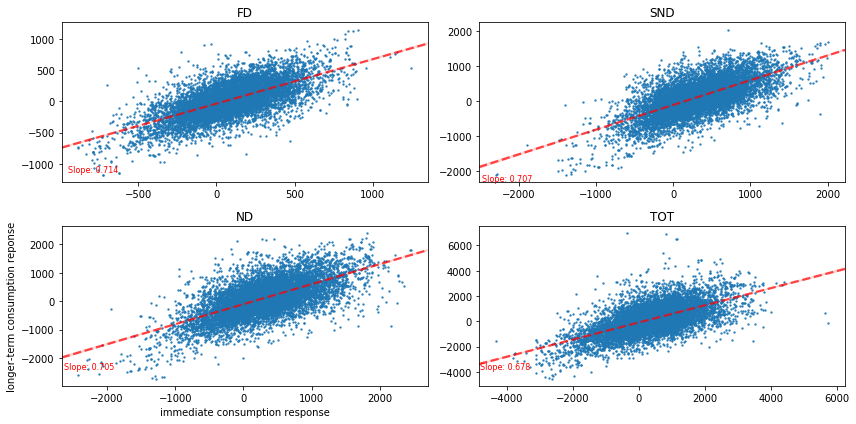

In [55]:
fig=plt.figure(figsize=(12,6))
for i,c in enumerate(['FD','SND','ND','TOT']): #,'SND','ND','TOT']:
    plot = plt.subplot(2,2,i+1) 
    ax = seaborn.regplot(x=cr_cumcons[f'treat1_cr_{c}_nofin'],y=cr_cumcons[f'treat2_cr_{c}_nofin'],  line_kws={"color": "red", "alpha":0.7, "linestyle": "dashed"}, marker='o', scatter_kws={'s':2})
    print(cr_cumcons[f'treat1_cr_{c}_nofin'].corr(cr_cumcons[f'treat2_cr_{c}_nofin']))
    slopey = ax.get_lines()[0].get_ydata()[0:2]
    print(slopey)
    slopex = ax.get_lines()[0].get_xdata()[0:2]
    print(slopex)
    xpos = slopex[0] + 40 #cr_cumcons[f'treat1_cr_{c}_nofin'].min()-10
    ypos = slopey[0] - 400#cr_cumcons[f'treat2_cr_{c}_nofin'].min()+abs(cr_cumcons[f'treat2_cr_{c}_nofin'].min())/1.5
    if (i==2):
        plt.xlabel('immediate consumption response')
    else:
        plt.xlabel('')
    if (i == 2):
        plt.ylabel('longer-term consumption reponse')
    else:
        plt.ylabel('')
    plt.title(c)
    plt.text(xpos, ypos, 'Slope: {:.3f}'.format((slopey[1]-slopey[0])/(slopex[1]-slopex[0])) ,fontsize=8, color='red')
    plt.tight_layout()
plt.savefig(os.getcwd() + f'\\condistr\\allcons_cumulative_scatter.pdf') 
plt.show()

In [134]:
#cr_cumcons = cr_cumcons.iloc[:2634]
cr_des_list = []
mpc_des_list = []
for i,c in enumerate(['FD','SND','ND','TOT']):
    cr_des_list = cr_des_list + [f'cumcons_cr_{c}_nofin']
    mpc_des_list = mpc_des_list + [f'cumcons_mpc_{c}_nofin']
    if i == 0:
        des_cumcons = pd.DataFrame(cr_cumcons[f'cumcons_cr_{c}_nofin'].describe().round(1))
        des_cumcons = des_cumcons.join(pd.DataFrame(mpc_cumcons[f'cumcons_mpc_{c}_nofin'].describe().round(3)))
    else:
        des_cumcons = des_cumcons.join(pd.DataFrame(cr_cumcons[f'cumcons_cr_{c}_nofin'].describe().round(1)))
        des_cumcons = des_cumcons.join(pd.DataFrame(mpc_cumcons[f'cumcons_mpc_{c}_nofin'].describe().round(3)))
    #longterm.join(pd.DataFrame(mpc, columns=['mpc_'+k.split('_')[0]+'_'+k.split('_')[1]]).describe().round(3))

index1 = [i.split('_')[2] for i in list(des_cumcons)]
#index1 = ['cons. resp.' for i in index1]
#print(index1)
index2 = [i.split('_')[1] for i in list(des_cumcons)]
index2 = ['fraction' if i=='mpc' else 'cons. resp.' for i in index2]
tuples = list(zip(index1,index2))
des_cumcons.columns = pd.MultiIndex.from_tuples(tuples)
    
    
print(cr_des_list)
print(mpc_des_list)
cr_cumcons[cr_des_list].describe()
print(des_cumcons.iloc[0:].to_latex(multicolumn_format='c'))
#print(mpc_pred.iloc[1:].to_latex(float_format="{:,.3f}".format,multicolumn_format='c'))#table1

['cumcons_cr_FD_nofin', 'cumcons_cr_SND_nofin', 'cumcons_cr_ND_nofin', 'cumcons_cr_TOT_nofin']
['cumcons_mpc_FD_nofin', 'cumcons_mpc_SND_nofin', 'cumcons_mpc_ND_nofin', 'cumcons_mpc_TOT_nofin']
\begin{tabular}{lrrrrrrrr}
\toprule
{} & \multicolumn{2}{c}{FD} & \multicolumn{2}{c}{SND} & \multicolumn{2}{c}{ND} & \multicolumn{2}{c}{TOT} \\
{} & cons. resp. &   fraction & cons. resp. &   fraction & cons. resp. &   fraction & cons. resp. &   fraction \\
\midrule
count &     10608.0 &  10608.000 &     10608.0 &  10608.000 &     10608.0 &  10608.000 &     10608.0 &  10608.000 \\
mean  &       111.4 &      0.178 &       408.5 &      0.599 &       404.1 &      0.623 &       561.1 &      0.923 \\
std   &       452.6 &      2.271 &       829.7 &      5.376 &      1048.4 &      6.241 &      1862.6 &     11.330 \\
min   &     -1902.6 &    -25.881 &     -4393.3 &    -71.622 &     -5000.1 &    -77.348 &     -7215.6 &   -103.557 \\
25\%   &      -152.8 &     -0.167 &       -78.2 &     -0.090 &      -20

10608
10608
10608
10608
cumcons_cr_TOT_nofin


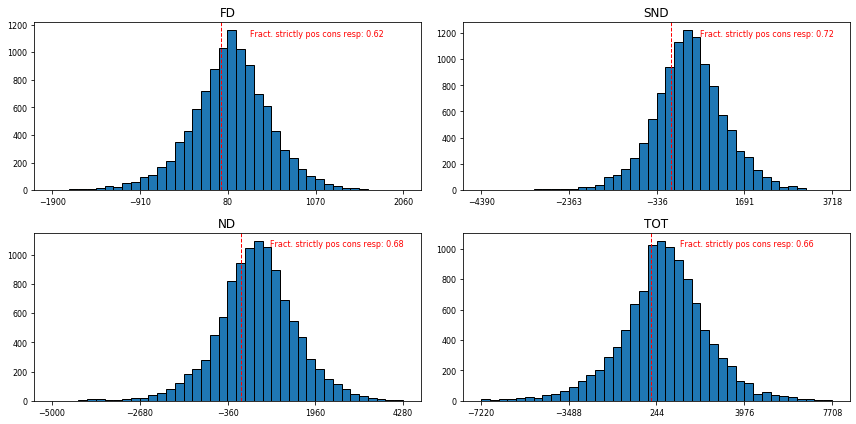

In [136]:
CONS = cr_des_list
fintype = ['nofin']
#rfdicts_keys = list(rfdicts)

fig=plt.figure(figsize=(12,6))

for i,c in enumerate(CONS):
    #c = 'cont1'
    #t= 'treat1'
    plot = plt.subplot(2,2,i+1)    
    y = np.array(cr_cumcons[[c]])
    #plot.hist(y, bins=40,  edgecolor='black', cumulative = True, density=True)
    plot.hist(y, bins=40,  edgecolor='black', cumulative = False)
    lower = np.round((min(y)/100),1)*100
    upper = np.round((max(y)/100),1)*100+1
    ticks = int((upper-lower)/4)
    plt.xticks(np.arange(lower, upper, ticks), fontsize = 8)
    plt.axvline(0, color='red', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    print(y.shape[0])
    plt.text(ticks/3, max_ylim*0.92, 'Fract. strictly pos cons resp: {:.2f}'.format((y>0).sum()/y.shape[0]) ,fontsize=8, color='red') #(y>0).sum()/y.shape[0]
    plt.title(c.split('_')[2])
    plt.tight_layout()
    plt.yticks(fontsize=8)
    #if i == 2:
        #plt.ylabel('households in bin')
    #    plt.xlabel('predicted consumption response')
    #plt.savefig(os.getcwd() + f'\\condistr\\{CONS[0]}_{CONS[1]}_{c}_{t}_{f}.pdf') #figure 1
plt.savefig(os.getcwd() + f'\\condistr\\allcons_cumulative.pdf') #figure 1
#fig.suptitle(f'Predicted consumption response')
print(c)
plt.show()    

Plot partial dependeny as comparison between the different specifications for a given control group and type of consumption

In [146]:
import pandas as pd
import numpy as np
import io
import requests
import os
import zipfile
import urllib.request
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import PercentFormatter #plot as percentage
import seaborn #plot density and histogram at the same time
# Set directory where files are downloaded to. Chdir has to be changed in order to run on another computer
os.chdir('C:\\Users\justu\\Desktop\\Masterarbeit\\Data\\CE') #change this to the folder where the data set is stored, all the results will be saved in the same folder


In [147]:
#five variables to plot: income, age, finanassets, mortgage, education; education is categorical all are stored in different csv files
#generate list of tuples for filename and variable


('INCOME', 'FINCBTXM')
finit_cont1_treat1_INCOME.csv
nofin_cont1_treat1_INCOME.csv
finit_cont1_treat1_INCOME.csv
nofin_cont1_treat1_INCOME.csv
finit_cont1_treat1_INCOME.csv
nofin_cont1_treat1_INCOME.csv
finit_cont1_treat1_INCOME.csv
nofin_cont1_treat1_INCOME.csv
('MORTGAGE', 'qblncm1x_sum')
finit_cont1_treat1_MORTGAGE.csv
nofin_cont1_treat1_MORTGAGE.csv
finit_cont1_treat1_MORTGAGE.csv
nofin_cont1_treat1_MORTGAGE.csv
finit_cont1_treat1_MORTGAGE.csv
nofin_cont1_treat1_MORTGAGE.csv
finit_cont1_treat1_MORTGAGE.csv
nofin_cont1_treat1_MORTGAGE.csv
('age', 'age')
finit_cont1_treat1_age.csv
nofin_cont1_treat1_age.csv
finit_cont1_treat1_age.csv
nofin_cont1_treat1_age.csv
finit_cont1_treat1_age.csv
nofin_cont1_treat1_age.csv
finit_cont1_treat1_age.csv
nofin_cont1_treat1_age.csv
('INCOME', 'FINCBTXM')
finit_cont1_treat1_INCOME.csv
nofin_cont1_treat1_INCOME.csv
finit_cont1_treat1_INCOME.csv
nofin_cont1_treat1_INCOME.csv
finit_cont1_treat1_INCOME.csv
nofin_cont1_treat1_INCOME.csv
finit_cont1_treat1

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\justu\\Desktop\\Masterarbeit\\Data\\CE\\pdp\\pdp_mpc_qblncm1x_sum_cont2_treat2.pdf'

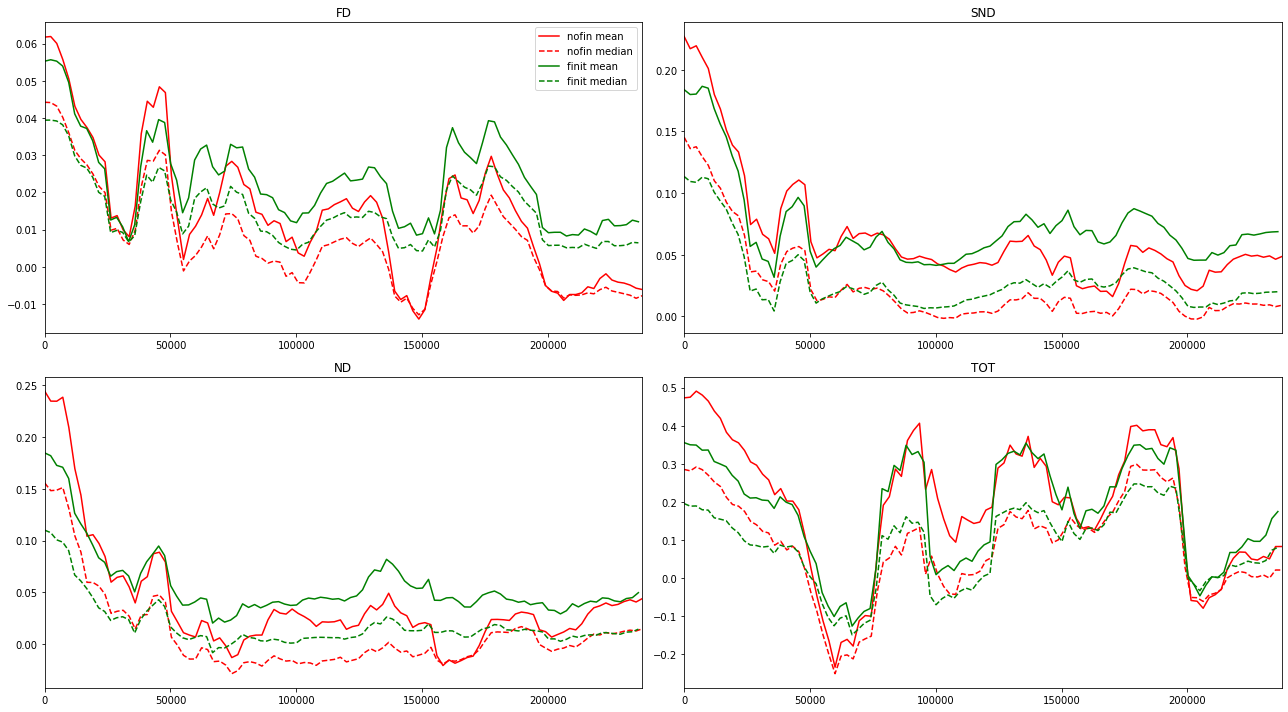

In [333]:
pdp_tuples = [('INCOME','FINCBTXM'),('MORTGAGE','qblncm1x_sum'),('age','age')] #,('MORTGAGE','timeleft')
consumption = ['FD','SND','ND','TOT']
crtype = ['cr','mpc']
ct_tuples = [('treat1','cont1'),('treat2','cont2'),('treat1','cont2')]
for ct in ct_tuples:
    control = ct[1]
    treatment = ct[0]
    for cr in crtype:
        for t in pdp_tuples:
            print(t)
            fig = plt.figure(figsize=(18, 10))
            pdp_plot_dict = dict()
            for c,cons in enumerate(consumption):
                path = os.getcwd()+f'\\pdp\\{cons}'
                pdp_list = os.listdir(path)
                #plot income
                pdp_list = [p for p in pdp_list if (p.split('_')[0]=='finit') | (p.split('_')[0]=='nofin') if
                            p.split('_')[3]==f'{t[0]}.csv' if p.split('_')[1]==control if p.split('_')[2]==treatment]
                for i,p in enumerate(pdp_list):
                    pdp_plot = pd.read_csv(f'{path}\\{p}')
                    print(p)
                    colnames = list(pdp_plot)
                    expvar = t[1]
                    colnames = [c for c in colnames if c.split('_')[0]==expvar.split('_')[0]]
                    pdp_plot = pdp_plot.loc[:,colnames]
                    colrenames = [p.split('_')[0]+'_'+n for n in colnames]
                    rename = dict(zip(colnames,colrenames))
                    pdp_plot = pdp_plot.rename(columns=rename)
                    pdp_plot_dict[p] = pdp_plot

                for i,p in enumerate(pdp_list):
                    if i == 0:
                        pdp_plot = pdp_plot_dict[p]
                    else:
                        pdp_plot = pdp_plot.join(pdp_plot_dict[p])
                #display(pdp_plot.head())
                plot = plt.subplot(int(len(consumption)/2),2,c+1)
                colors=['red','green']
                for j,i in enumerate(['nofin','finit']):
                    plt.plot(pdp_plot[f'{i}_{expvar}_grid'],pdp_plot[f'{i}_{expvar}_{cr}_mean'],label=f'{i} mean', color=colors[j])
                    plt.margins(x=0)
                    plt.plot(pdp_plot[f'{i}_{expvar}_grid'],pdp_plot[f'{i}_{expvar}_{cr}_median'],label=f'{i} median', color=colors[j], linestyle='dashed')
                    plt.margins(x=0)
                if c==0:
                    plt.legend()
                plt.title(cons, fontsize=12)
            plt.tight_layout()
            plt.savefig(os.getcwd()+f'\\pdp\\pdp_{cr}_{t[1]}_{control}_{treatment}.pdf')
            plt.close()
#expvars = list(set([c.split('_')[0] for c in colnames]))[1:]
#types = [c.lstrip(c.split('_')[0]) for c in colnames]
#plt.plot(pdp_plot[colnames[1]],pdp_plot[colnames[2]])
#colnames
#pdp_plot[colnames[2]]

('INCOME', 'FINCBTXM')
['nofin_cont2_treat1_INCOME.csv', 'nofin_cont2_treat2_INCOME.csv']
nofin_cont2_treat1_INCOME.csv
nofin_cont2_treat2_INCOME.csv
['nofin_cont2_treat1_INCOME.csv', 'nofin_cont2_treat2_INCOME.csv']
nofin_cont2_treat1_INCOME.csv
nofin_cont2_treat2_INCOME.csv
['nofin_cont2_treat1_INCOME.csv', 'nofin_cont2_treat2_INCOME.csv']
nofin_cont2_treat1_INCOME.csv
nofin_cont2_treat2_INCOME.csv
['nofin_cont2_treat1_INCOME.csv', 'nofin_cont2_treat2_INCOME.csv']
nofin_cont2_treat1_INCOME.csv
nofin_cont2_treat2_INCOME.csv
FINCBTXM


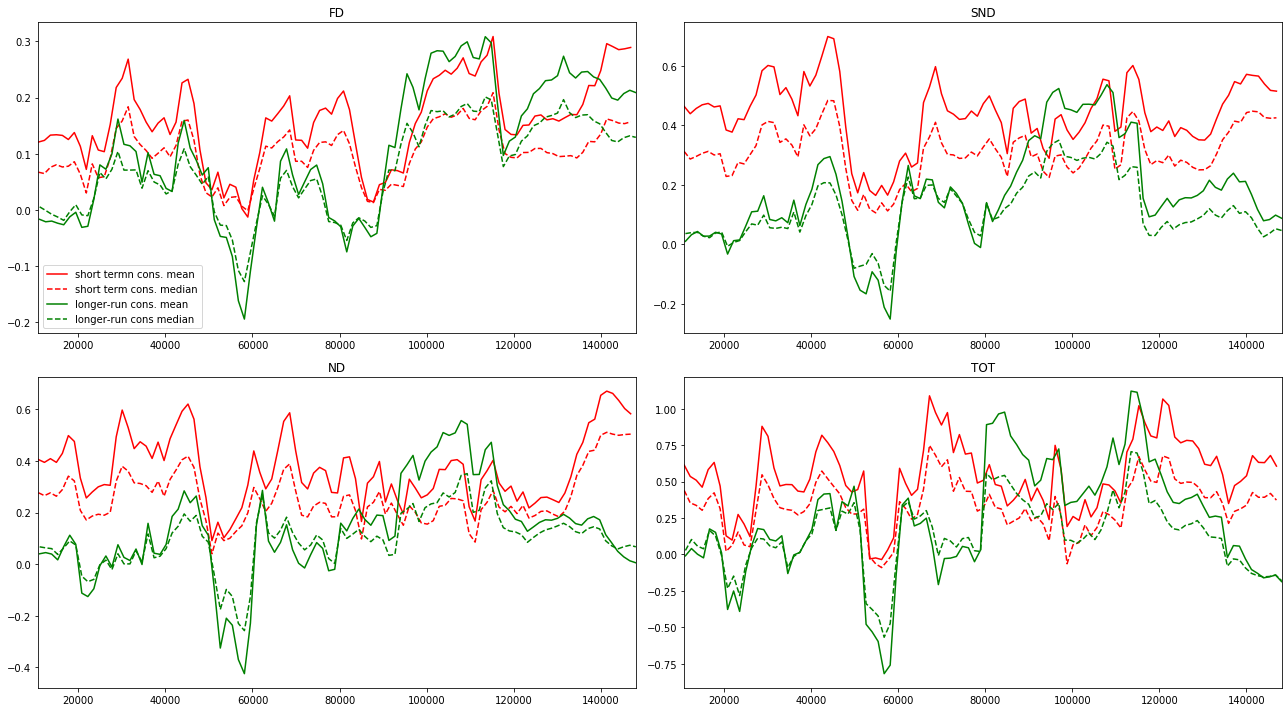

('MORTGAGE', 'qblncm1x_sum')
['nofin_cont2_treat1_MORTGAGE.csv', 'nofin_cont2_treat2_MORTGAGE.csv']
nofin_cont2_treat1_MORTGAGE.csv
nofin_cont2_treat2_MORTGAGE.csv
['nofin_cont2_treat1_MORTGAGE.csv', 'nofin_cont2_treat2_MORTGAGE.csv']
nofin_cont2_treat1_MORTGAGE.csv
nofin_cont2_treat2_MORTGAGE.csv
['nofin_cont2_treat1_MORTGAGE.csv', 'nofin_cont2_treat2_MORTGAGE.csv']
nofin_cont2_treat1_MORTGAGE.csv
nofin_cont2_treat2_MORTGAGE.csv
['nofin_cont2_treat1_MORTGAGE.csv', 'nofin_cont2_treat2_MORTGAGE.csv']
nofin_cont2_treat1_MORTGAGE.csv
nofin_cont2_treat2_MORTGAGE.csv
qblncm1x_sum


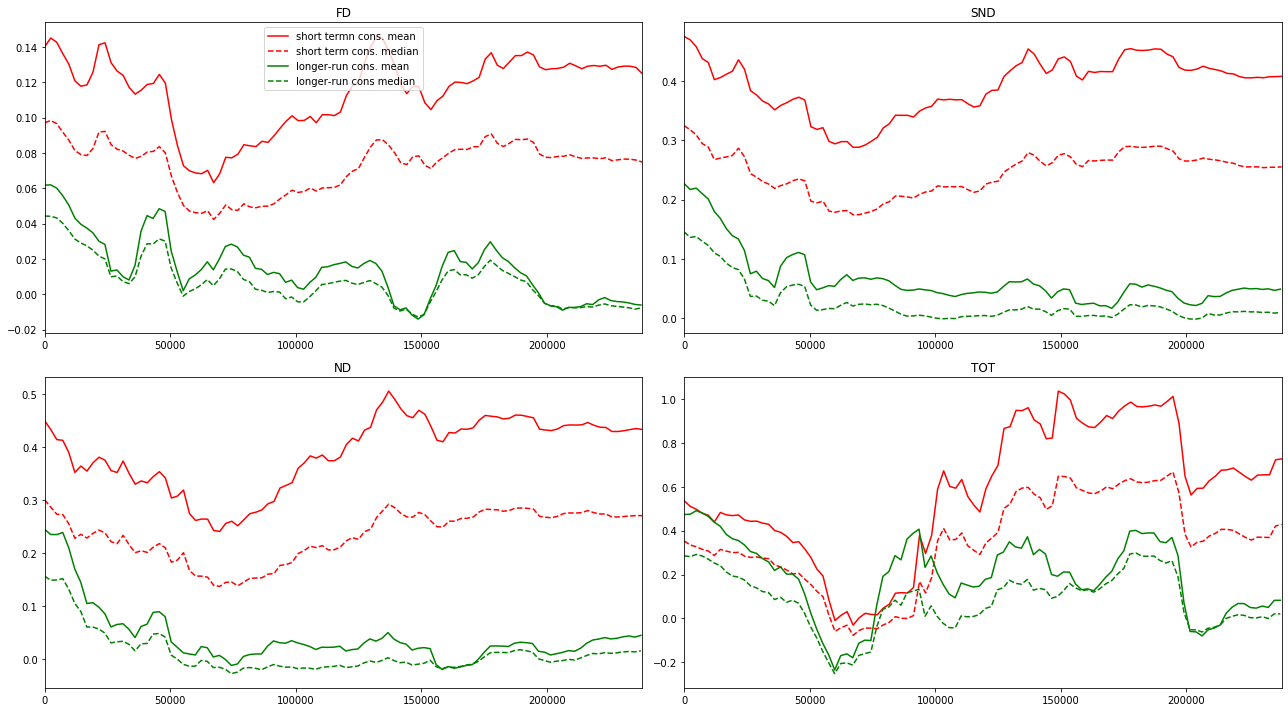

('age', 'age')
['nofin_cont2_treat1_age.csv', 'nofin_cont2_treat2_age.csv']
nofin_cont2_treat1_age.csv
nofin_cont2_treat2_age.csv
['nofin_cont2_treat1_age.csv', 'nofin_cont2_treat2_age.csv']
nofin_cont2_treat1_age.csv
nofin_cont2_treat2_age.csv
['nofin_cont2_treat1_age.csv', 'nofin_cont2_treat2_age.csv']
nofin_cont2_treat1_age.csv
nofin_cont2_treat2_age.csv
['nofin_cont2_treat1_age.csv', 'nofin_cont2_treat2_age.csv']
nofin_cont2_treat1_age.csv
nofin_cont2_treat2_age.csv
age


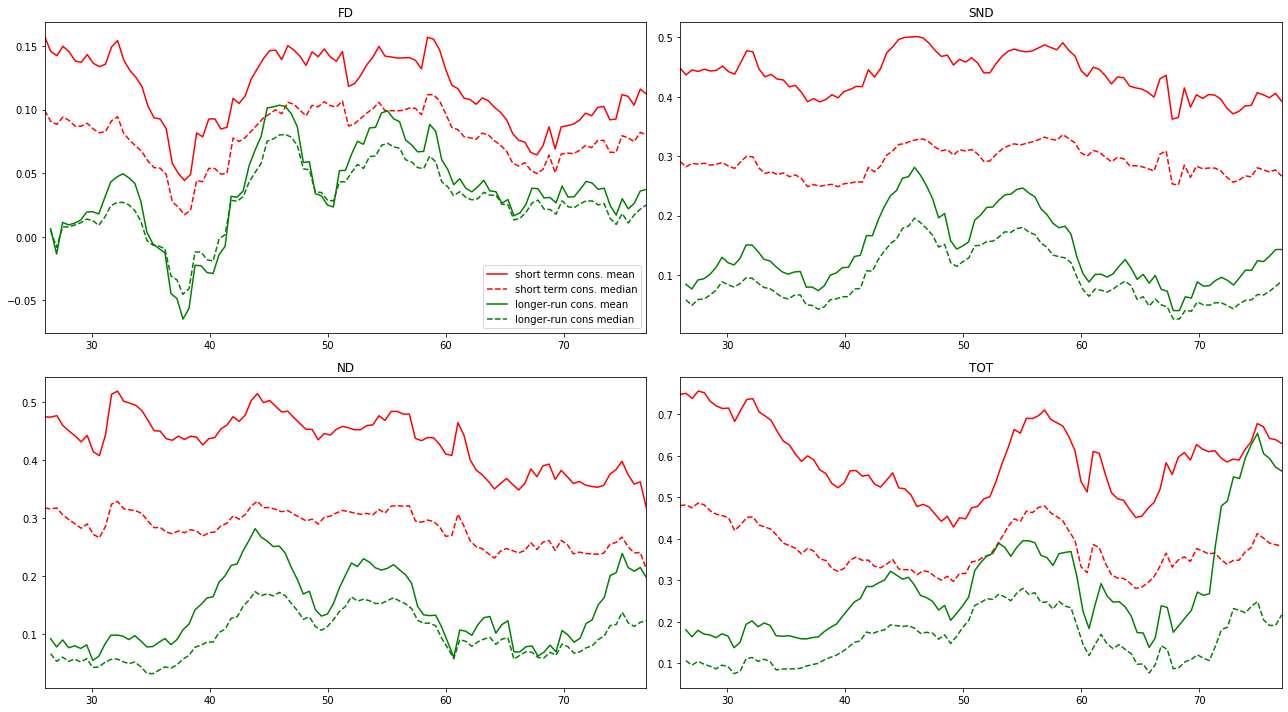

In [348]:
pdp_tuples = [('INCOME','FINCBTXM'),('MORTGAGE','qblncm1x_sum'),('age','age')] #,('MORTGAGE','timeleft')
consumption = ['FD','SND','ND','TOT']
crtype = ['cr','mpc']
ct_tuples = [('treat1','cont1'),('treat2','cont2'),('treat1','cont2')]

for t in pdp_tuples:
    print(t)
    fig = plt.figure(figsize=(18, 10)) 
    for c,cons in enumerate(consumption):
        path = os.getcwd()+f'\\pdp\\{cons}'
        pdp_list = os.listdir(path)
    #plot income
        pdp_list = [p for p in pdp_list if (p.split('_')[0]=='nofin') if
                p.split('_')[3]==f'{t[0]}.csv' if p.split('_')[1]=='cont2' if (p.split('_')[2]=='treat1') | (p.split('_')[2]=='treat2')]
        print(pdp_list)
        pdp_plot_dict = dict()
        for i,p in enumerate(pdp_list):
            pdp_plot = pd.read_csv(f'{path}\\{p}')
            print(p)
            colnames = list(pdp_plot)
            expvar = t[1]
            colnames = [c for c in colnames if c.split('_')[0]==expvar.split('_')[0]]
            #print(colnames)
            pdp_plot = pdp_plot.loc[:,colnames]
            colrenames = [p.split('_')[1]+'_'+p.split('_')[2]+'_'+n for n in colnames]
            rename = dict(zip(colnames,colrenames))
            pdp_plot = pdp_plot.rename(columns=rename)
            pdp_plot_dict[p] = pdp_plot
            #display(pdp_plot.head())
        for i,p in enumerate(pdp_list):
            if i == 0:
                pdp_plot = pdp_plot_dict[p]
            else:
                pdp_plot = pdp_plot.join(pdp_plot_dict[p])
        #display(pdp_plot.head())
        plot = plt.subplot(int(len(consumption)/2),2,c+1)
        colors=['red','green']
        plt.plot(pdp_plot[f'cont2_treat1_{expvar}_grid'],pdp_plot[f'cont2_treat1_{expvar}_{cr}_mean'],label=f'short termn cons. mean', color='red')
        plt.margins(x=0)
        plt.plot(pdp_plot[f'cont2_treat1_{expvar}_grid'],pdp_plot[f'cont2_treat1_{expvar}_{cr}_median'],label=f'short term cons. median', color='red', linestyle='dashed')
        plt.margins(x=0)
        plt.plot(pdp_plot[f'cont2_treat2_{expvar}_grid'],pdp_plot[f'cont2_treat2_{expvar}_{cr}_mean'],label=f'longer-run cons. mean', color='green')
        plt.margins(x=0)
        plt.plot(pdp_plot[f'cont2_treat2_{expvar}_grid'],pdp_plot[f'cont2_treat2_{expvar}_{cr}_median'],label=f'longer-run cons median', color='green', linestyle='dashed')
        if c==0:
            plt.legend()
        plt.title(cons, fontsize=12)
    plt.tight_layout()
    plt.savefig(os.getcwd()+f'\\pdp\\pdp_{cr}_{t[1]}_shortlong_compare.pdf')
    print(expvar)
    plt.show()


In [149]:
pdp_tuples = [('CAT_1','CUTENURE_'),('CAT_3','educ_')]
educ = ['nodegree','highschool','higher']
ct_tuples = [('treat1','cont1'),('treat2','cont2')]
for ct in ct_tuples:
    treatment = ct[0]
    control = ct[1]
    consumption = ['FD','SND','ND','TOT']
    for t in pdp_tuples:
        ax = dict()
        fig, (ax[0],ax[1]) = plt.subplots(1,2, figsize=(20,6))

        for j,types in enumerate(['finit','nofin']):
            pdp_car_dict = dict()
            for c in consumption:
                carvar_means = []
                path = os.getcwd()+f'\\pdp\\{c}'
                pdp_list = os.listdir(path)
                pdp_list = [p for p in pdp_list if  (p.split('_')[0]==types) if p[-9:-4]==f'{t[0]}' if p.split('_')[1]==control if p.split('_')[2]==treatment] ##(p.split('_')[0]=='finit') |
                for p in pdp_list:
                    pdp_plot = pd.read_csv(f'{path}\\{p}')
                    catvars = [v for v in list(pdp_plot) if v[-6:]=='median' if v[0:3]=='mpc']
                    if 'mpc_CUTENURE_5_median' in catvars:
                        print('check')
                        pdp_plot = pdp_plot.drop(columns='mpc_CUTENURE_5_median')
                        catvars = [v for v in catvars if v!='mpc_CUTENURE_5_median']
                    labels = [v[4:-7] for v in catvars]
                    catvars_val = [pdp_plot.loc[0,v] for v in catvars]
                    catvars_tuples = list(zip(catvars,catvars_val))
                    #print(catvars_tuples)
                    pdp_car_dict[f'{c}_tuples'] = catvars_tuples
                    pdp_car_dict[f'{c}_values'] = catvars_val
                    #pdp_car_dict[f'{c}_rects'] = ax.bar(x - width/2, catvars_val, width, label=c)

                        # Add some text for labels, title and custom x-axis tick labels, etc.



            #plt.subplot(2,1,j+1)


            #f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
            width = 0.23
            x = np.arange(len(labels))
            #print(x-width/2)
            #print((x-width/2)/2)
            #print((x-width/2)/2+0.0875)
            pos = (x-width/2)-width
            hatch = ['','/','//','\\']
            #print(pos)
            for i,c in enumerate(consumption):
                #print(x-width/4)
                pdp_car_dict[f'{c}_rects'] = ax[j].bar(pos, pdp_car_dict[f'{c}_values'], width, label=c, hatch=hatch[i])
                pos = pos +width
                #print(pos)
                def autolabel(rects):
                    """Attach a text label above each bar in *rects*, displaying its height."""
                    for rect in rects:
                        height = rect.get_height()
                        ax[j].annotate('{:,.2f}'.format(height),
                                    xy=(rect.get_x() + rect.get_width() / 2, height-0.005),
                                    xytext=(0, 3),  # 3 points vertical offset
                                    textcoords="offset points",
                                    fontsize=12,
                                    ha='center', va='bottom')


                autolabel(pdp_car_dict[f'{c}_rects'])
            #ax.set_ylabel('Scores')
            #ax.set_title('Scores by group and gender')
            #ax.set_title("Title for second plot")
            ax[j].set_title(types)
            ax[j].set_xticks(x)
            ax[j].set_xticklabels(labels)
            if j == 0:
                ax[j].legend()
            else:
                pass
        fig.tight_layout()
        plt.savefig
        plt.savefig(os.getcwd()+f'\\pdp\\pdp_mpc_{t[1]}_{control}_{treatment}.pdf')
        plt.close()

check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check


In [349]:
fs08_cap.loc[fs08_cap['treat2']==1,:].count()

CustID             3221
QINTRVMO           3221
QINTRVYR           3221
rbtmo_1             443
rbtmo_2             443
diff_1              443
diff_2              443
NEWID              3221
FD                 3221
SND                3221
ND                 3221
DUR                3221
TOT                3221
age                3221
adults             3221
PERSLT18           3221
FSALARYM           3221
FINCBTXM           3221
valid_finassets    3221
finassets           708
morgpayment        3221
qblncm1x_sum       3221
qescrowx_sum       3221
timeleft           3221
rbtamt                0
rbtamt_chk            0
rbtamt_e              0
rbtamt_1            443
rbtamt_2            443
last_rbtamt        3221
                   ... 
lrun_DUR           3221
lrun_TOT           3221
chg_FD             2778
chg_SND            2778
chg_ND             2778
chg_DUR            2778
chg_TOT            2778
educ_nodegree      3221
educ_highschool    3221
educ_higher        3221
CUTENURE_1      

In [725]:
control = 'cont1'
treatment = 'treat1'
consumption = ['FD','SND','ND','TOT']
crtype = ['cr','mpc']
pdp_tuples = [('INCOME','finassets_it')]
for cr in crtype:
    for t in pdp_tuples:
        fig = plt.figure(figsize=(18, 10))
        for c,cons in enumerate(consumption):
            path = os.getcwd()+f'\\pdp\\{cons}'
            pdp_list = os.listdir(path)
            #plot income
            pdp_list = [p for p in pdp_list if (p.split('_')[0]=='fin') | (p.split('_')[0]=='finit') if p.split('_')[3]==f'{t[0]}.csv' if p.split('_')[1]==control if p.split('_')[2]==treatment]
            pdp_plot_dict = dict()
            for i,p in enumerate(pdp_list):
                pdp_plot = pd.read_csv(f'{path}\\{p}')
                #display(pdp_plot.head())
                colnames = list(pdp_plot)
                expvar = t[1]
                colnames = [c for c in colnames if c.split('_')[0]==expvar.split('_')[0]]
                pdp_plot = pdp_plot.loc[:,colnames]
                colrenames = [p.split('_')[0]+'_'+n for n in colnames]
                rename = dict(zip(colnames,colrenames))
                pdp_plot = pdp_plot.rename(columns=rename)
                pdp_plot_dict[p] = pdp_plot

            for i,p in enumerate(pdp_list):
                if i == 0:
                    pdp_plot = pdp_plot_dict[p]
                else:
                    pdp_plot = pdp_plot.join(pdp_plot_dict[p])
            pdp_plot.loc[pdp_plot[f'fin_finassets_grid']>pdp_plot[f'finit_finassets_it_grid'].max(),[f'fin_finassets_{cr}_mean',f'fin_finassets_{cr}_median']] =np.nan
            plot = plt.subplot(int(len(consumption)/2),2,c+1)
            colors=['red','green']
            for j,i in enumerate(['finit','fin']):
                if i == 'fin':
                    expvar = 'finassets'
                else:
                    expvar = 'finassets_it'
                plt.plot(pdp_plot[f'{i}_{expvar}_grid'],pdp_plot[f'{i}_{expvar}_{cr}_mean'],label=f'{i} median', color=colors[j])
                plt.margins(x=0)
                plt.plot(pdp_plot[f'{i}_{expvar}_grid'],pdp_plot[f'{i}_{expvar}_{cr}_median'],label=f'{i} median', color=colors[j], linestyle='dashed')
                plt.margins(x=0)
            if c==0:
                plt.legend()
            plt.title(cons, fontsize=12)
        plt.tight_layout()
        plt.savefig(os.getcwd()+f'\\pdp\\pdp_{cr}_{t[1]}_{control}_{treatment}.pdf')
        plt.close()
#expvars = list(set([c.split('_')[0] for c in colnames]))[1:]
#types = [c.lstrip(c.split('_')[0]) for c in colnames]
#plt.plot(pdp_plot[colnames[1]],pdp_plot[colnames[2]])
#colnames
#pdp_plot[colnames[2]]